In [156]:
import torch
import torch.nn as nn
from torchviz import make_dot
import torch.fx as fx
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
import matplotlib.animation as animation
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from datetime import datetime, timedelta
import time
import random

## Config

In [32]:
# Set the font style for the figure
plt.rcParams['font.family'] = 'monospace'  # Change to desired font family (e.g., 'serif', 'sans-serif', 'monospace')
plt.rcParams['font.size'] = 14  # Change the font size as needed

## Computer Network Visualization

In [138]:
def create_base_graph():
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes representing SRNs
    G.add_nodes_from(['SRN 1', 'SRN 2', 'SRN 3', 'SRN 4'])

    # Add edges representing the connections between SRNs
    G.add_edges_from([('SRN 1', 'SRN 2'), 
                      ('SRN 2', 'SRN 3'),
                      ('SRN 2', 'SRN 4'),
                      ('SRN 3', 'SRN 4'),
                      ('SRN 4', 'SRN 1')])

    # Define custom colors for each SRN
    node_colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon']

    # Positions for each node
    pos = {'SRN 1': [-1, 0],
           'SRN 2': [0,  1],
           'SRN 3': [1,  0],
           'SRN 4': [0, -1]}

    # Initialize lists for active nodes and edges
    active_edges = []
    active_nodes = []

    # Draw the base graph
    draw_graph(G, pos, active_edges, active_nodes)

    return G, pos, active_edges, active_nodes

def draw_graph(G, pos, active_edges, active_nodes):
    
    # Define custom colors for each SRN
    node_colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon']
    
    # Draw nodes with their current colors
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, edgecolors='black', node_size=2000)

    # Draw all edges with default colors
    nx.draw_networkx_edges(G, pos, width=2, arrows=False)

    # Highlight active edges
    if active_edges:
        nx.draw_networkx_edges(G, pos, edgelist=active_edges, edge_color='green', style='dashed', width=8, arrows=True, arrowsize=20, node_size=1100)

    # Highlight active nodes by their active colors
    active_colors = ['blue', 'green', 'red', 'salmon']
    for node in active_nodes:
        node_index = list(G.nodes()).index(node)
        node_colors[node_index] = active_colors[node_index]

    # Draw nodes again to make active nodes appear on top
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, edgecolors='black', node_size=2000)

    # Draw labels next to the nodes
    nx.draw_networkx_labels(G, pos, font_size=12, font_color="black", font_family='monospace', verticalalignment='center')

    # Show the updated graph
    plt.title("SRN Network")
    plt.tight_layout()
    plt.axis('off')
    plt.show()

def toggle_edge(G, pos, edge, active_edges, active_nodes):
    if edge in active_edges:
        # If edge is already active, deactivate it
        active_edges.remove(edge)
    else:
        # If edge is not active, activate it
        active_edges.append(edge)

    # Redraw the full graph
    draw_graph(G, pos, active_edges, active_nodes)

    return active_edges

def toggle_node(G, pos, node, active_edges, active_nodes):
    if node in active_nodes:
        # If node is already active, deactivate it
        active_nodes.remove(node)
    else:
        # If node is not active, activate it
        active_nodes.append(node)

    # Redraw the full graph
    draw_graph(G, pos, active_edges, active_nodes)

    return active_nodes


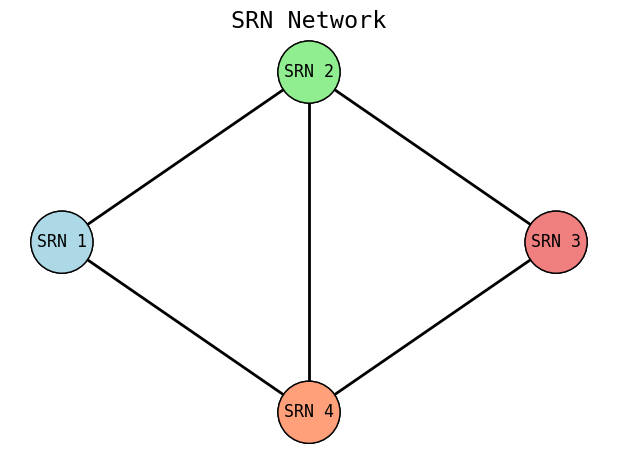

In [139]:
G, pos, active_edges, active_nodes = create_base_graph()

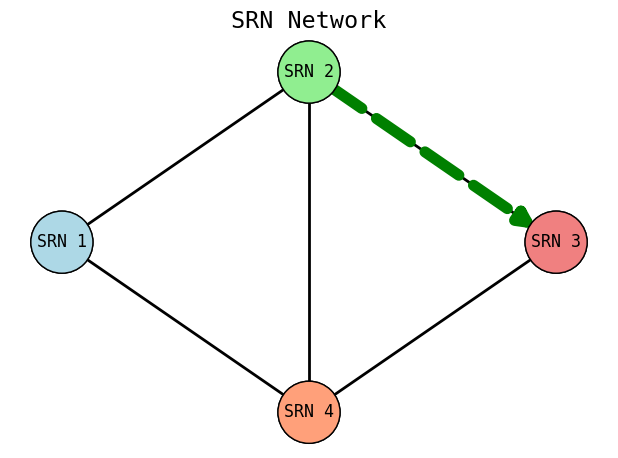

In [140]:
active_edges = toggle_edge(G, pos, ('SRN 2', 'SRN 3'), active_edges, active_nodes)

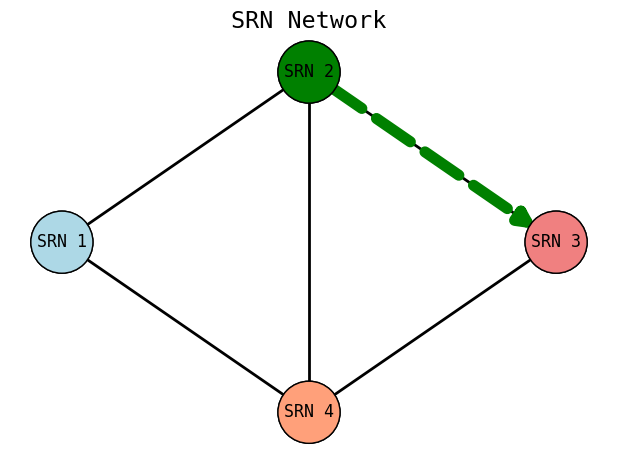

In [141]:
active_nodes = toggle_node(G, pos, 'SRN 2', active_edges, active_nodes)

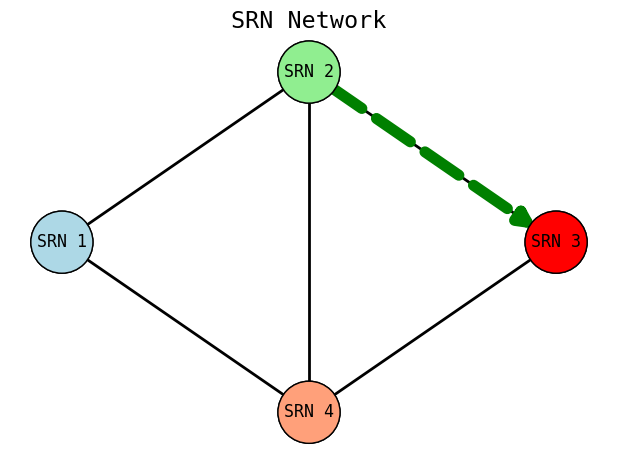

In [143]:
active_nodes = toggle_node(G, pos, 'SRN 3', active_edges, active_nodes)

## Loading Bar

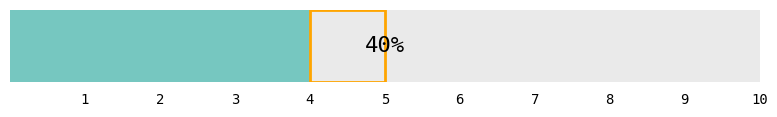

In [128]:
def plot_loading_bar(total_layers, current_layer):
    """
    Visualizes a loading bar representing the progress through a neural network's layers.
    
    Parameters:
    - total_layers: The total number of layers in the network.
    - current_layer: The current layer being processed (1-indexed).
    """
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 1.5))
    
    # Set axis limits
    ax.set_xlim(0, total_layers)
    ax.set_ylim(0, 1)
    
    # Disable the axes for a clean look
    ax.axis('off')

    # Define colors for the loading bar
    bar_background_color = '#EAEAEA'  # Light grey background for the loading bar
    bar_color = '#76C7C0'  # Teal color for the progress
    current_layer_color = '#FFA500'  # Orange color for the current layer highlight

    # Add background rectangle for the loading bar
    ax.add_patch(Rectangle((0, 0), total_layers, 1, color=bar_background_color, lw=0))

    # Add filled portion for the progress bar
    ax.add_patch(Rectangle((0, 0), current_layer-1, 1, color=bar_color, lw=0))

    # Add a highlight border for the current layer
    ax.add_patch(Rectangle((current_layer - 1, 0), 1, 1, fill=False, edgecolor=current_layer_color, lw=2))

    # Add progress percentage text in the middle of the bar
    progress_percentage = int(((current_layer-1) / total_layers) * 100)
    ax.text(total_layers / 2, 0.5, f'{progress_percentage}%', ha='center', va='center', fontsize=16, color='black')

    # Add markers for each layer number
    for layer in range(total_layers):
        ax.text(layer + 1, -0.25, f'{layer + 1}', ha='center', va='center', fontsize=10, color='black')
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage
plot_loading_bar(total_layers=10, current_layer=5)

## Neural Network Visualization

### Torch fx

In [130]:
class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()
        # Define the layers of the CNN
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # Assuming input images are 28x28, downsampled by pooling
        self.fc2 = nn.Linear(128, 10)  # Output for 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = torch.max_pool2d(x, 2)  # Downsample by 2x

        x = self.conv2(x)
        x = torch.relu(x)
        x = torch.max_pool2d(x, 2)  # Downsample by 2x again

        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = SmallCNN()

# Test input to match the input size (batch_size=1, channels=1, height=28, width=28)
dummy_input = torch.randn(1, 1, 28, 28)


In [131]:
# Trace the model using torch.fx
traced_model = fx.symbolic_trace(model)

# Print the traced graph to verify
print(traced_model.graph)

graph():
    %x : [num_users=1] = placeholder[target=x]
    %conv1 : [num_users=1] = call_module[target=conv1](args = (%x,), kwargs = {})
    %relu : [num_users=1] = call_function[target=torch.relu](args = (%conv1,), kwargs = {})
    %max_pool2d : [num_users=1] = call_function[target=torch.max_pool2d](args = (%relu, 2), kwargs = {})
    %conv2 : [num_users=1] = call_module[target=conv2](args = (%max_pool2d,), kwargs = {})
    %relu_1 : [num_users=1] = call_function[target=torch.relu](args = (%conv2,), kwargs = {})
    %max_pool2d_1 : [num_users=2] = call_function[target=torch.max_pool2d](args = (%relu_1, 2), kwargs = {})
    %size : [num_users=1] = call_method[target=size](args = (%max_pool2d_1, 0), kwargs = {})
    %view : [num_users=1] = call_method[target=view](args = (%max_pool2d_1, %size, -1), kwargs = {})
    %fc1 : [num_users=1] = call_module[target=fc1](args = (%view,), kwargs = {})
    %relu_2 : [num_users=1] = call_function[target=torch.relu](args = (%fc1,), kwargs = {})
    

In [132]:
from torch.fx.graph import Graph
from torchviz import make_dot

# Convert the traced model graph into a torchviz representation
def visualize_fx_graph(traced_model):
    # Create a dot graph visualization using torchviz
    output = traced_model(torch.randn(1, 1, 28, 28))  # Generate output from dummy input
    dot = make_dot(output, params=dict(traced_model.named_parameters()))

    # Render and display the dot graph
    dot.render("cnn_fx_graph", format="png")
    dot.view()

# Call the visualization function
visualize_fx_graph(traced_model)

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


### Other

In [197]:
# Function to visualize the CNN input/output channel assignment as a matrix
def visualize_cnn_matrix(channel_assignment):
    """
    Visualizes the CNN channel assignment as a matrix where rows represent input channels
    and columns represent output channels. Cells are colored according to the SRN handling them.

    Parameters:
    - channel_assignment: A dictionary where keys are SRNs and values are tuples with:
      1. The input channels the SRN has.
      2. The output channels the SRN is computing.
    """
    # Node colors for SRNs
    node_colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon']

    # Get all input and output channels across all SRNs
    input_channels = set()
    output_channels = set()

    for srn, (input_chs, output_chs) in channel_assignment.items():
        input_channels.update(input_chs)
        output_channels.update(output_chs)

    # Sort the input and output channels
    input_channels = sorted(input_channels)
    output_channels = sorted(output_channels)

    # Create a matrix to represent the input/output channel assignments
    matrix = np.zeros((len(input_channels), len(output_channels)))

    # Create a mapping from SRN to color index
    srn_to_color_idx = {srn: i for i, srn in enumerate(channel_assignment.keys())}

    # Fill in the matrix with the SRN assignments
    for srn, (input_chs, output_chs) in channel_assignment.items():
        color_idx = srn_to_color_idx[srn]  # Get the color index for the SRN
        for input_ch in input_chs:
            if input_ch in input_channels:
                input_idx = input_channels.index(input_ch)
                for output_ch in output_chs:
                    if output_ch in output_channels:
                        output_idx = output_channels.index(output_ch)
                        matrix[input_idx, output_idx] = color_idx + 1  # Use color index

    # Create a custom colormap with the specified node colors
    cmap = ListedColormap(node_colors)

    # Plot the matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot the matrix with the custom colormap
    cax = ax.imshow(matrix, cmap=cmap, origin='upper')

    # Add color bar for the legend
    cbar = fig.colorbar(cax, ticks=np.arange(0.5, len(node_colors) + 0.5), orientation='vertical')
    cbar.ax.set_yticklabels([f'SRN {i + 1}' for i in range(len(node_colors))])

    # Set the ticks for input and output channels
    ax.set_xticks(np.arange(len(output_channels)))
    ax.set_yticks(np.arange(len(input_channels)))

    # Label the axes with input and output channels
    ax.set_xticklabels([f'Out {ch}' for ch in output_channels])
    ax.set_yticklabels([f'In {ch}' for ch in input_channels])

    # Rotate the x-axis labels for better visibility
    plt.xticks(rotation=45, ha='right')

    # Add titles and labels
    ax.set_title('Input/Output Channel Assignment by SRN')
    ax.set_xlabel('Output Channels')
    ax.set_ylabel('Input Channels')

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()


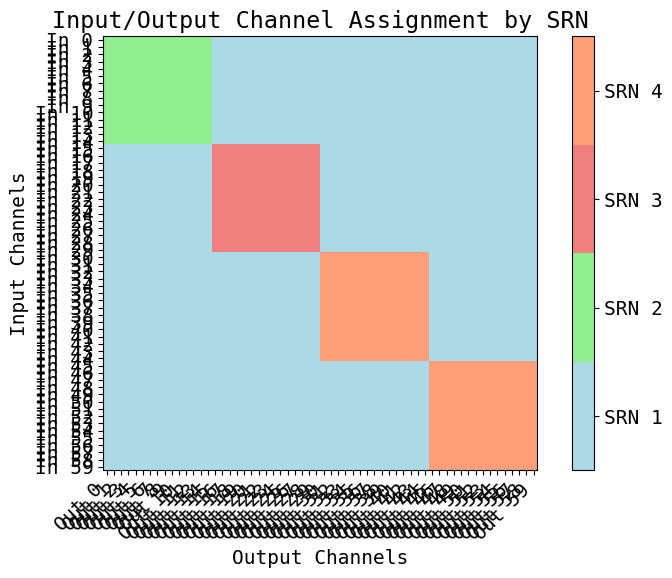

In [198]:
# Example usage
channel_assignment = {
    "SRN 1": (range(15), range(15)),
    "SRN 2": (range(15, 30), range(15, 30)),
    "SRN 3": (range(30, 45), range(30, 45)),
    "SRN 4": (range(45, 60), range(45, 60))
}

visualize_cnn_matrix(channel_assignment)

In [211]:
def plot_cnn_layer_distribution_equal_length(channel_partitions, node_colors):
    """
    Plots the distribution of CNN input channels across machines (SRNs) for each layer,
    with equal vertical line lengths (same height for all layers, channels scaled by height).

    Parameters:
    - channel_partitions: List of lists, where each inner list represents a layer's channel assignment to machines (SRNs).
                          The value of each element in the inner list is an integer representing the machine number (0 to 3).
    - node_colors: List of colors for the SRNs.
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create legend for SRNs
    legend_patches = [mpatches.Patch(color=color, label=f'SRN {i}') for i, color in enumerate(node_colors)]
    plt.legend(handles=legend_patches, title='SRN Assignments', loc='upper right')

    max_channels = max(len(partition) for partition in channel_partitions)  # Max channels to scale all lines to this height

    # Plot each layer
    for layer_idx, partitions in enumerate(channel_partitions):
        num_channels = len(partitions)
        box_height = max_channels / num_channels  # Scale box height based on the number of channels

        for channel_idx, srn in enumerate(partitions):
            # Plot a rectangle (representing a channel) for each channel in the layer
            rect = mpatches.Rectangle((layer_idx, channel_idx * box_height), 0.8, box_height, 
                                      facecolor=node_colors[srn], edgecolor='black')
            ax.add_patch(rect)

        # Add a label for the layer
        ax.text(layer_idx + 0.4, max_channels + 0.5, f'conv{layer_idx + 1}', ha='center', va='center', fontsize=10)

    # Set the limits and labels
    ax.set_xlim(-0.5, len(channel_partitions) + 0.5)
    ax.set_ylim(-0.5, max_channels + 1)
    ax.set_xticks([])  # Remove x-ticks
    ax.set_yticks([])  # Remove y-ticks

    ax.set_title('CNN Input Channel Distribution Across SRNs')
    plt.tight_layout()
    plt.show()


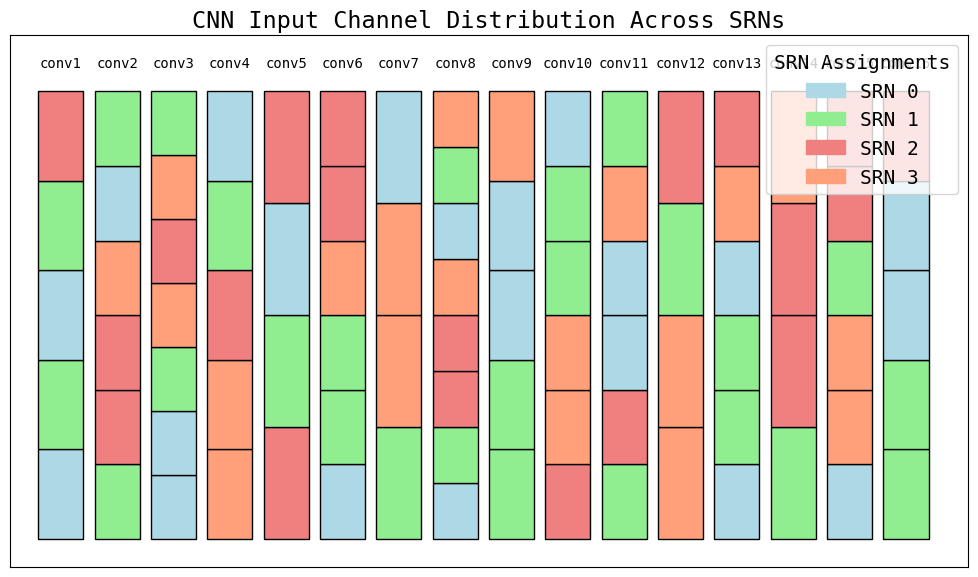

In [212]:
# Example usage with 16 layers and variable number of channels
channel_partitions_deep = [
    [0, 1, 0],                   # conv1, 3 channels
    [1, 2, 2, 3, 0, 1, 0, 0, 1, 3, 2, 3, 1],          # conv2, 6 channels
    [0, 0, 1, 3, 2, 3, 1],       # conv3, 7 channels
    [3, 3, 2, 1, 0],             # conv4, 5 channels
    [2, 1, 0, 2],                # conv5, 4 channels
    [0, 1, 1, 3, 2, 2],          # conv6, 6 channels
    [1, 3, 3, 0],                # conv7, 4 channels
    [0, 1, 2, 2, 3, 0, 1, 3],    # conv8, 8 channels
    [1, 1, 0, 0, 3],             # conv9, 5 channels
    [2, 3, 3, 1, 1, 0],          # conv10, 6 channels
    [1, 2, 0, 0, 3, 1],          # conv11, 6 channels
    [3, 3, 1, 2],                # conv12, 4 channels
    [0, 1, 1, 0, 3, 2],          # conv13, 6 channels
    [1, 2, 2, 3],                # conv14, 4 channels
    [0, 3, 3, 1, 2, 2],          # conv15, 6 channels
    [1, 1, 0, 0, 2]              # conv16, 5 channels
]

# Plot the deeper network with equal height lines
plot_cnn_layer_distribution_equal_length(channel_partitions_deep, node_colors)

## Total Transmitted Data Visualization

In [186]:
# Function to update and replot the graph
def update_graph(ax, all_timestamps, cumulative_data):
    """
    Replot the graph from scratch with new cumulative transmission data.

    Parameters:
    - ax: The axis object to plot on.
    - all_timestamps: A list of time (in seconds since start) for each transmission.
    - cumulative_data: A list of lists, where each list contains the cumulative transmitted KBytes for each machine.
    """
    # Clear the current axis (replot from scratch)
    ax.clear()

    # Set labels and title again since clearing the axis removes them
    ax.set_title("Cumulative Transmitted KBytes Over Time")
    ax.set_xlabel("Time (seconds since start)")
    ax.set_ylabel("Cumulative Transmitted KBytes")

    # Plot the new data for each machine
    ax.plot(all_timestamps, cumulative_data[0], label="SRN 1", marker='o', color="blue")
    ax.plot(all_timestamps, cumulative_data[1], label="SRN 2", marker='o', color="green")
    ax.plot(all_timestamps, cumulative_data[2], label="SRN 3", marker='o', color="red")
    ax.plot(all_timestamps, cumulative_data[3], label="SRN 4", marker='o', color="orange")

    # Add the legend again after replotting
    ax.legend()

    # Adjust the axis limits based on the new data
    ax.relim()
    ax.autoscale_view()

# Sample function to simulate adding new data
def add_new_data(all_timestamps, transmitted_data, cumulative_data, current_time, start_time, new_data):
    """
    Add new transmission data to the existing data and update the cumulative sum.

    Parameters:
    - all_timestamps: A list of existing time (in seconds since start).
    - transmitted_data: A list of lists of transmitted KBytes for each machine.
    - cumulative_data: A list of lists for cumulative transmitted KBytes.
    - current_time: The current timestamp.
    - start_time: The start time of the transmissions.
    - new_data: A list of transmitted KBytes (one for each machine).
    """
    # Calculate the time in seconds since start
    time_since_start = (current_time - start_time).total_seconds()
    all_timestamps.append(time_since_start)

    # Append the new data to each machine's list of transmitted KBytes
    for i, data in enumerate(new_data):
        transmitted_data[i].append(data)
        # Calculate the cumulative sum for the current machine
        cumulative_data[i].append(np.sum(transmitted_data[i]))


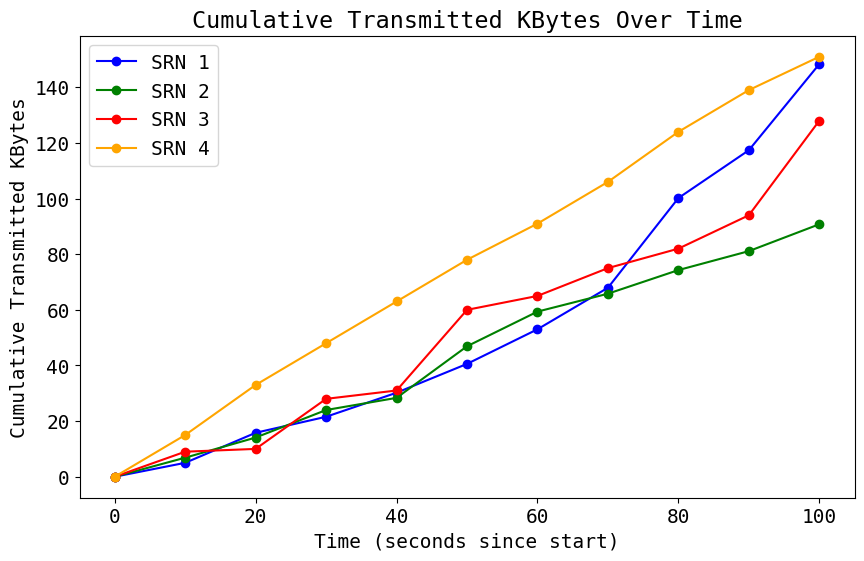

In [188]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# List to store time (in seconds since start) of transmissions
all_timestamps = [0]

# Lists to store transmitted KBytes and cumulative transmitted KBytes for each machine
transmitted_data = [[0], [0], [0], [0]]  # One list per machine
cumulative_data = [[0], [0], [0], [0]]  # Cumulative transmitted data for each machine

# Set the start time
start_time = datetime.now()

# Simulate multiple updates (e.g., 10 updates)
current_time = start_time
for i in range(10):
    # Simulate current time (increment by 10 seconds for each update)
    current_time += timedelta(seconds=10)

    # Simulate non-linear transmission data for each machine (in KBytes)
    new_data = [
        random.randint(1, 10) * (1.2 ** i),  # Machine 1: Increasing with some randomness
        random.randint(5, 15) * (1 + (random.random() - 0.5)),  # Machine 2: Random fluctuations
        random.randint(0, 5) ** 2 + i,  # Machine 3: Quadratic increase with base noise
        15 + random.randint(-3, 3) * (i % 2)  # Machine 4: Randomly fluctuating around 15
    ]

    # Add new transmission data to the lists and update cumulative sum
    add_new_data(all_timestamps, transmitted_data, cumulative_data, current_time, start_time, new_data)

# Replot the graph after adding all updates
update_graph(ax, all_timestamps, cumulative_data)

# Show the snapshot
plt.show()

## Summary

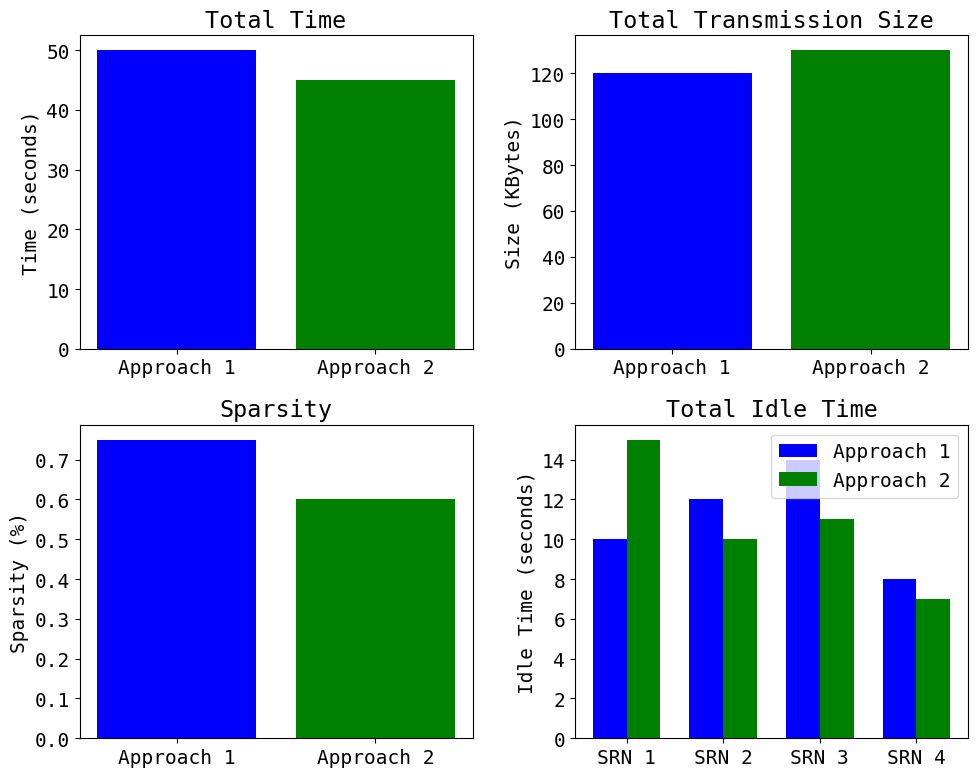

In [190]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for each metric for both approaches
approach_1_data = {
    "Total Time": 50,
    "Total Transmission Size": 120,
    "Sparsity": 0.75,
    "Total Idle Time": [10, 12, 14, 8]
}

approach_2_data = {
    "Total Time": 45,
    "Total Transmission Size": 130,
    "Sparsity": 0.60,
    "Total Idle Time": [15, 10, 11, 7]
}

# Create a figure and a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Define the labels for the metrics
metrics = ["Total Time", "Total Transmission Size", "Sparsity", "Total Idle Time"]

# Plot 1: Total Time
axes[0, 0].bar(["Approach 1", "Approach 2"], [approach_1_data["Total Time"], approach_2_data["Total Time"]], color=['blue', 'green'])
axes[0, 0].set_title("Total Time")
axes[0, 0].set_ylabel("Time (seconds)")

# Plot 2: Total Transmission Size
axes[0, 1].bar(["Approach 1", "Approach 2"], [approach_1_data["Total Transmission Size"], approach_2_data["Total Transmission Size"]], color=['blue', 'green'])
axes[0, 1].set_title("Total Transmission Size")
axes[0, 1].set_ylabel("Size (KBytes)")

# Plot 3: Sparsity
axes[1, 0].bar(["Approach 1", "Approach 2"], [approach_1_data["Sparsity"], approach_2_data["Sparsity"]], color=['blue', 'green'])
axes[1, 0].set_title("Sparsity")
axes[1, 0].set_ylabel("Sparsity (%)")

# Plot 4: Total Idle Time (4 bars per approach)
# We'll need to create 4 bars for each approach
idle_labels = ['SRN 1', 'SRN 2', 'SRN 3', 'SRN 4']
x = np.arange(len(idle_labels))  # Label locations

# Set width for each bar
width = 0.35

# Create bars for both approaches
axes[1, 1].bar(x - width/2, approach_1_data["Total Idle Time"], width, label='Approach 1', color='blue')
axes[1, 1].bar(x + width/2, approach_2_data["Total Idle Time"], width, label='Approach 2', color='green')

# Labeling the bars and axes
axes[1, 1].set_title("Total Idle Time")
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(idle_labels)
axes[1, 1].set_ylabel("Idle Time (seconds)")

# Add a legend to the last plot
axes[1, 1].legend()

# Adjust the layout so the plots don't overlap
plt.tight_layout()

# Display the plot
plt.show()
